In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from glob import glob 
from fastcore.xtras import load_pickle

import matplotlib.pyplot as plt 
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['science', 'nature'])

import matplotx

import pandas as pd 
import numpy as np

%matplotlib inline

In [3]:
all_res = glob('out/**/*.pkl')

In [4]:
compiled_res = []
compiled_gpr = []

for res in all_res:
    loaded = load_pickle(res)
    repre = loaded['representation']
    num_points = loaded['num_train_points']

    metrics = {
        'representation': loaded['representation'],
        'num_train_points': loaded['num_train_points'],
        'mae': loaded['mean_absolute_error'],
        'max_error': loaded['max_error'],
        'mse': loaded['mean_squared_error']
    }

    compiled_res.append(metrics)


    gpr_metrics = {
        'num_train_points': loaded['num_train_points'],
        'mae': loaded['gpr_baseline']['mean_absolute_error'],
        'max_error': loaded['gpr_baseline']['max_error'],
        'mse': loaded['gpr_baseline']['mean_squared_error']
    }

    compiled_gpr.append(gpr_metrics)

In [5]:
compiled_res = pd.DataFrame(compiled_res)
compiled_gpr = pd.DataFrame(compiled_gpr)

In [6]:
compiled_grouped_res = compiled_res.groupby(['representation', 'num_train_points']).agg(['mean', 'std'])

In [7]:
compiled_gpr_grouped = compiled_gpr.groupby(['num_train_points']).agg(['mean', 'std'])

In [8]:
compiled_grouped_res

mae           max_error            \
                                    mean       std      mean       std   
representation num_train_points                                          
smiles         10                3.47992  0.358515   18.8460  3.625876   
               20                3.26048  0.384098   23.5550  0.751377   
               50                2.69529  0.061274   19.0825  1.650098   
               100               2.70338  0.292940   19.4550  0.176777   
               200               1.41032  0.103973   12.9050  1.859691   

                                       mse            
                                      mean       std  
representation num_train_points                       
smiles         10                19.842545  2.986773  
               20                19.310904  3.173651  
               50                13.666322  0.494862  
               100               14.057225  2.123633  
               200                4.456968  0.124775

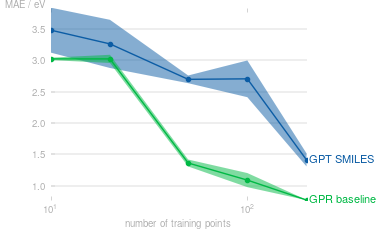

In [9]:
with plt.style.context(matplotx.styles.dufte):
    fig, ax = plt.subplots(1,1)
    # ax.plot(
    #     compiled_grouped_res.loc["SELFIES", :].index, 
    #     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'], 
    #     label='GPT SELFIES', 
    #     marker='o'
    # )

    # ax.fill_between(
    #     compiled_grouped_res.loc["SELFIES", :].index, 
    #     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'] - compiled_grouped_res.loc["SELFIES", :]['mae']['std'], 
    #     compiled_grouped_res.loc["SELFIES", :]['mae']['mean'] + compiled_grouped_res.loc["SELFIES", :]['mae']['std'], 
    # )

    ax.plot(
        compiled_grouped_res.loc["smiles", :].index, 
        compiled_grouped_res.loc["smiles", :]['mae']['mean'], 
        label='GPT SMILES',
        marker='o'
    )

    ax.fill_between(
        compiled_grouped_res.loc["smiles", :].index, 
        compiled_grouped_res.loc["smiles", :]['mae']['mean'] - compiled_grouped_res.loc["smiles", :]['mae']['std'], 
        compiled_grouped_res.loc["smiles", :]['mae']['mean'] + compiled_grouped_res.loc["smiles", :]['mae']['std'], 
        alpha=.5
    )

    ax.plot(
        compiled_gpr_grouped.loc[:].index, 
        compiled_gpr_grouped['mae']['mean'], 
        label='GPR baseline',
        marker='o'
    )

    ax.fill_between(
        compiled_gpr_grouped.loc[ :].index, 
        compiled_gpr_grouped.loc[:]['mae']['mean'] - compiled_gpr_grouped.loc[ :]['mae']['std'], 
        compiled_gpr_grouped.loc[ :]['mae']['mean'] + compiled_gpr_grouped.loc[ :]['mae']['std'], 
        alpha=.5
    )

    matplotx.line_labels(fontsize=8)

    ax.set_xlabel('number of training points', labelpad=4)
    matplotx.ylabel_top('MAE / eV')
    ax.set_xscale('log')

fig.savefig('freesolv_regression_res.pdf', bbox_inches='tight')
